# Linear Regression Analysis
---
**Research question**: "How many friends does a person have based on how much time they spend alone, post online, and whether they go outside and attend social events?"

I want to estimate how many friends a person may have based on time spent alone, how often they post online, and whether they attend social events when going outside (interaction).

$y = Friend\ Circle\ Size$

$\beta_0 = Intercept$

$\beta_1 = Time\ spent\ alone$

$\beta_2 = Post\ frequency$

$\beta_3 = Going\ outside$

$\beta_4 = Social\ event\ attendance$

$$y = \beta_0 + \beta_1x + \beta_2z + \beta_2*\beta_3$$

**NOTE:**
- Each survey item scale may be normally distributed, but when combined may form a non-normally distributed dataset.
    - We care about the error term being normally distributed ($\epsilon \sim N(0, \sigma^2))$.
    - We can standardize the survey scales to be proportions: $\frac{x}{max(x)}$

In [631]:
import numpy as np
# Receive dataframe from Preprocessing
%store -r pre_df

pre_df["Personality"] = pre_df["Personality_Extrovert"]
pre_df = pre_df.drop(["Personality_Extrovert", "Personality_Introvert"], axis="columns")

# Apply transformation to each variable
for column in [
    "Time_spent_Alone",
    "Post_frequency",
    "Going_outside",
    "Social_event_attendance"
]:
    # Get proportion of responses.
    # pre_df[column] = pre_df[column] / max(pre_df[column])
    # Log transform
    pre_df[column] = np.where(pre_df[column] > 0, np.log(pre_df[column]), np.nan)
    # Square root transformation
    # pre_df[column] = np.sqrt(pre_df[column])

train_df = pre_df.sample(frac=0.8, random_state=1863)
test_df = pre_df.drop(train_df.index)

/Users/prokope/KState/STAT-705/Project/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


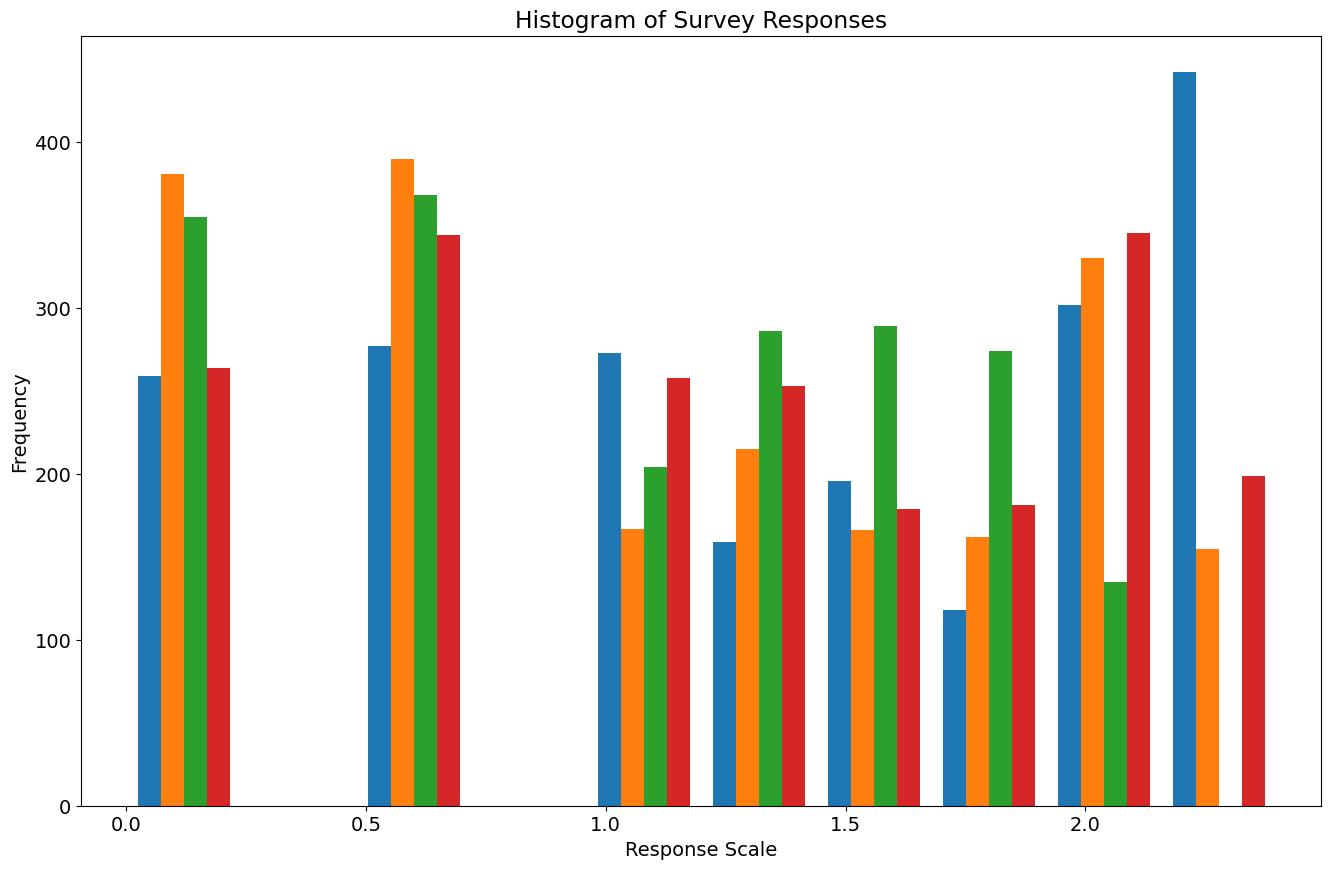

In [632]:
import matplotlib.pyplot as plt
predictors = train_df[
    ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]
]

# standard_scaler = lambda x: x / max(x)

# for column in [
#     "Time_spent_Alone",
#     "Post_frequency",
#     "Going_outside",
#     "Social_event_attendance"
# ]:
#     # transformed_df[column] = standard_scaler(transformed_df[column])
#     train_df[column] = train_df[column] / max(train_df[column])

plt.hist(predictors)
plt.title("Histogram of Survey Responses")
plt.xlabel("Response Scale")
plt.ylabel("Frequency")

plt.show()

In [633]:
from IPython.display import display_html

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

## Manual Linear Regression

In [634]:
import numpy as np
import pandas as pd

# See: https://ayoakin.medium.com/linear-regression-from-scratch-using-matrices-991df6e28f62

X = train_df[["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]].copy()
X["Going_outside:Social_event_attendance"] = train_df["Going_outside"] * train_df["Social_event_attendance"]
y = train_df[["Friends_circle_size"]].copy()

# Append column of 1s
X["Intercept"] = 1

# Transpose
X_T = X.T

# Calculate beta 1 using matrix form
B = np.linalg.inv(X_T @ X) @ (X_T @ y)

B.index = X.columns

# Compute predictions of y-hat using beta 1
predictions = X @ B

# Calculate Sum of Squares
SSR = ((y - predictions) ** 2).sum()
# Calculate Sum of Squares total
SST = ((y - y.mean()) ** 2).sum()
# Calculate R^2
R2 = 1 - (SSR / SST)

residuals = y - predictions

print("\nR-Squared: {}".format(R2.iloc[0]))
display_side_by_side(B, residuals.head())


R-Squared: 1.0


,Friends_circle_size
Time_spent_Alone,NaN
Post_frequency,NaN
Going_outside,NaN
Social_event_attendance,NaN
Going_outside:Social_event_attendance,NaN
Intercept,NaN
,Friends_circle_size
1385,NaN
320,NaN
37,NaN


## Linear Regression using `statsmodels`

In [635]:
from statsmodels.formula.api import ols

standard_scaler = lambda col: col / max(col)
transformed_df = train_df.copy()[[
    "Time_spent_Alone",
    "Post_frequency",
    "Going_outside",
    "Social_event_attendance",
    "Friends_circle_size",
]]

# for column in [
#     "Time_spent_Alone",
#     "Post_frequency",
#     "Going_outside",
#     "Social_event_attendance"
# ]:
#     # transformed_df[column] = standard_scaler(transformed_df[column])
#     transformed_df[column] = transformed_df[column] / max(train_df[column])

model = ols(
    formula='Friends_circle_size ~ Time_spent_Alone + Post_frequency + Going_outside + Social_event_attendance',
    data=transformed_df
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Friends_circle_size   R-squared:                       0.571
Model:                             OLS   Adj. R-squared:                  0.569
Method:                  Least Squares   F-statistic:                     414.9
Date:                 Sun, 13 Jul 2025   Prob (F-statistic):          1.90e-227
Time:                         11:09:07   Log-Likelihood:                -3040.2
No. Observations:                 1254   AIC:                             6090.
Df Residuals:                     1249   BIC:                             6116.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.8551      0.422      6.769      0.000       2.028       3.683
Time_spent_Alone           -0.9375      0.161     -5.823      0.000      -1.253      -0.622
Post_frequency              0.6690      0.186      3.595      0.000       0.304       1.034
Going_outside               2.0277      0.218      9.305      0.000       1.600       2.455
Social_event_attendance     1.6321      0.195      8.349      0.000       1.249       2.016
==============================================================================
Omnibus:                       42.530   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.858
Skew:                           0.222   Prob(JB):                     1.47e-06
Kurtosis:                       2.438   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Scale Predictors as Proportions
Each predictor has a different survey scale range (0-5, 0-7, 0-11, etc), so we need to scale each as a proportion $\frac{x}{max(x)}$.

In [636]:
test_df_scaled = test_df.copy()[[
    "Time_spent_Alone",
    "Post_frequency",
    "Going_outside",
    "Social_event_attendance",
    "Friends_circle_size",
    "Personality"
]]

# for column in [
#     "Time_spent_Alone",
#     "Post_frequency",
#     "Going_outside",
#     "Social_event_attendance"
# ]:
#     test_df_scaled[column] = test_df_scaled[column] / max(test_df[column])

# Combine scaled test data with predictions
test_df_scaled['Predicted'] = model.predict(test_df_scaled)

## (Optional) Switch Personality
We can switch the personality type of the observations to see the differences in the groups. Default setting will show data points from both introverts and extroverts. This is necessary as there are known outliers that may influence the inference of the model.

In [637]:
from enum import Enum

class Personality(Enum):
    introvert = (0, "Introvert")
    extrovert = (1, "Extrovert")

def switch_personality(personality: Personality | None = None):
    if personality:
        return test_df_scaled[test_df_scaled["Personality"] == personality.value[0]]
    else:
        return test_df_scaled

test_df_scaled = switch_personality()

## Plot regression model

### Decision (Tree) Linear Regression
Plot each predictor against the predicted friend circle size and compare against the actual data points. Some calibration is needed.

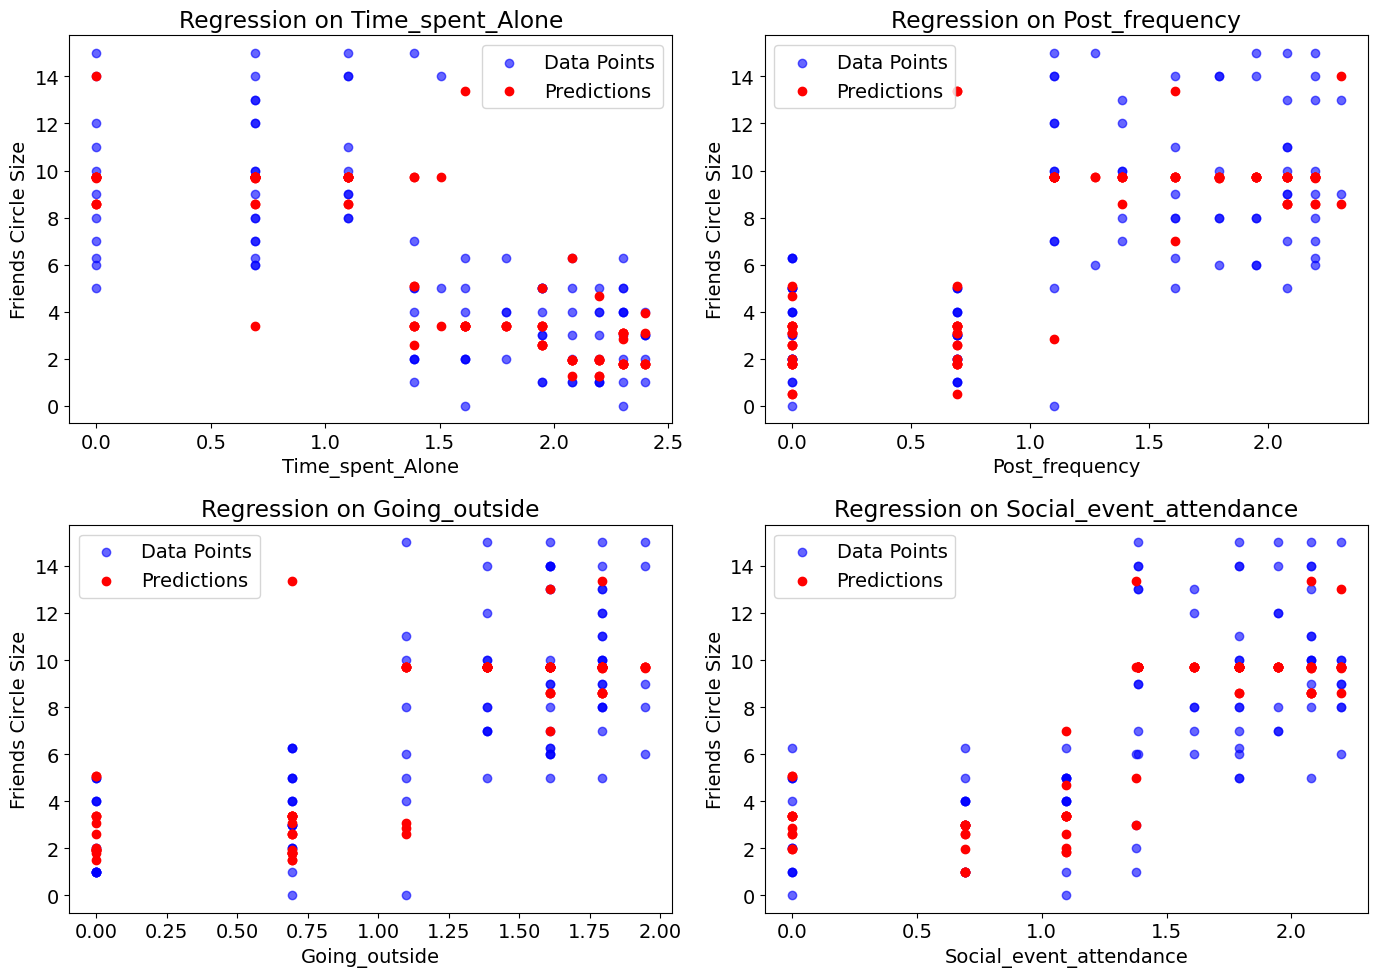

In [638]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, predictor in enumerate(predictors):
    ax = axs[i]
    X = test_df_scaled.drop('Friends_circle_size', axis=1)
    y = test_df_scaled['Friends_circle_size']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1863)

    # Create a DecisionTreeRegressor instance with maximum depth of 5
    dt_model = DecisionTreeRegressor(max_depth=5).fit(X_train, y_train)

    y_pred = dt_model.predict(X_test)

    ax.scatter(
        x=X_test[predictor],
        y=y_test,
        color="blue",
        alpha=0.6,
        label="Data Points"
    )
    ax.scatter(X_test[predictor], y_pred, color='red', label='Predictions')

    ax.set_title(f'Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Friends Circle Size')
    ax.legend()
plt.tight_layout()
plt.show()

### OLS Linear Regression with CI and PI
Plot OLS linear regression for each predictor against friend circle size with confidence and predictor intervals.

**NOTE:** Because each predictor influences each other when plotting data points, a linear space of data between the min and max of each predictor was needed to be generated. Additionally, each of the other predictors need to be held constant. This means that this test data is synthetic, but is used for model visualization and is not integrated into the test and train samples.

                             OLS Regression Results                            
Dep. Variable:     Friends_circle_size   R-squared:                       0.571
Model:                             OLS   Adj. R-squared:                  0.569
Method:                  Least Squares   F-statistic:                     414.9
Date:                 Sun, 13 Jul 2025   Prob (F-statistic):          1.90e-227
Time:                         11:09:08   Log-Likelihood:                -3040.2
No. Observations:                 1254   AIC:                             6090.
Df Residuals:                     1249   BIC:                             6116.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

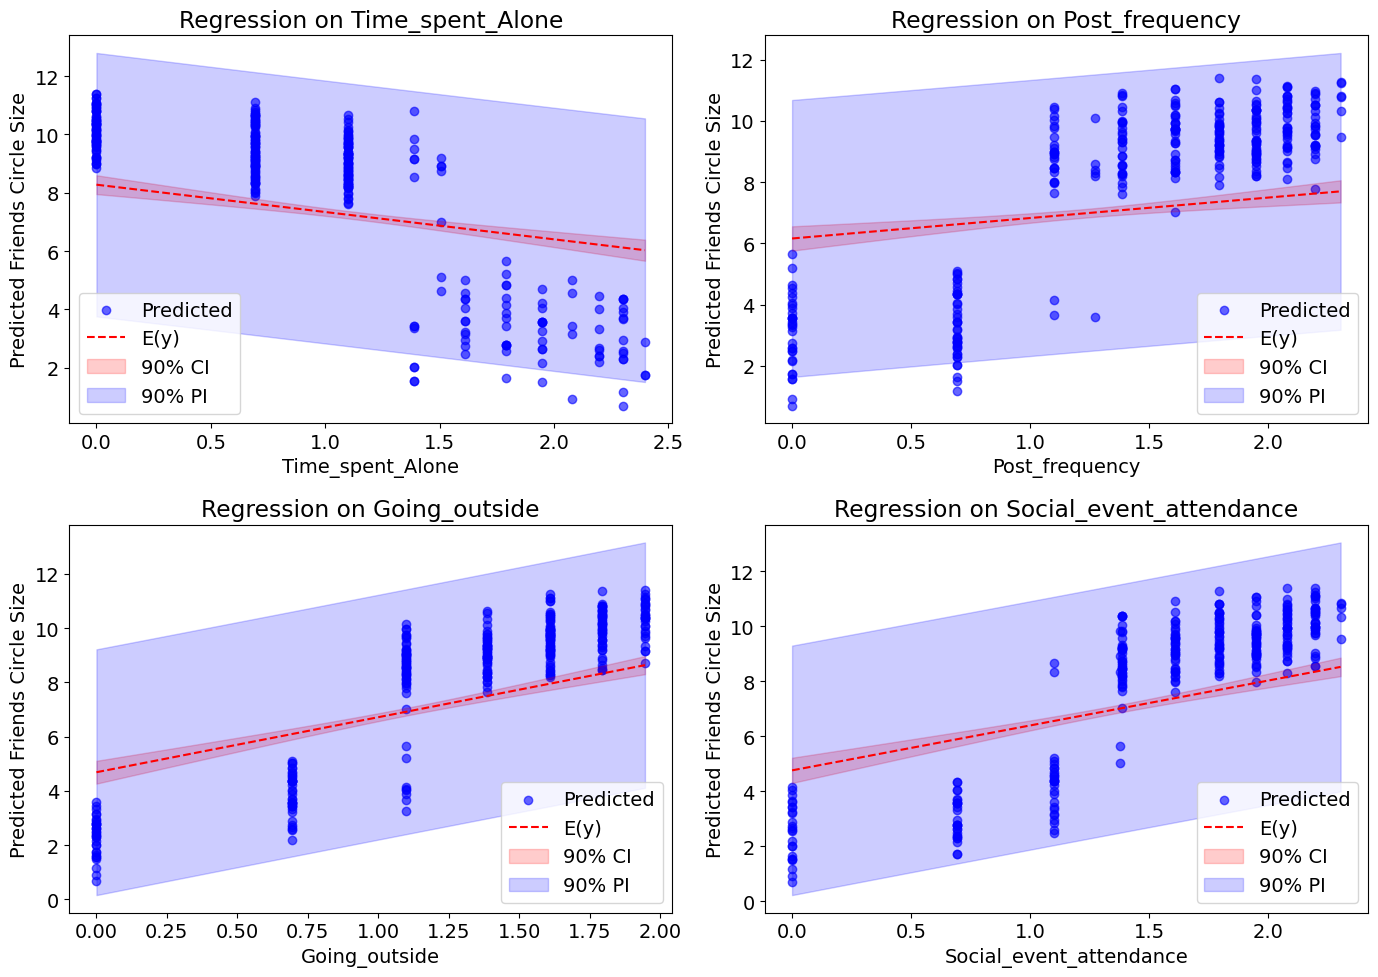

In [639]:
from scipy.stats import bootstrap

predictors = ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

print(model.summary())

for i, predictor in enumerate(predictors):
    ax = axs[i]

    # Isolate effects of each predictor and hold other predictors constant (at mean).
    # Generate synthetic data within bounds of predictor; used for testing model
    x_vals = np.linspace(test_df_scaled[predictor].min(), test_df_scaled[predictor].max(), 100)

    # Create a DataFrame with mean values for other predictors
    fixed_data = pd.DataFrame({
        col: [test_df_scaled[col].mean()] * len(x_vals) if col != predictor else x_vals
        for col in predictors
    })
    # fixed_data = fixed_data[predictors]  # Ensure column order

    pred = model.get_prediction(fixed_data)
    pred_summary = pred.summary_frame(alpha=0.10)

    # Plot points
    ax.scatter(
        test_df_scaled[predictor],
        test_df_scaled["Predicted"],
        color="blue",
        alpha=0.6,
        label="Predicted"
    )

    # Regression Line
    ax.plot(
        x_vals,
        pred_summary['mean'],
        color='red',
        label='E(y)',
        linestyle='--'
    )

    # Confidence interval
    ax.fill_between(
        x_vals,
        pred_summary['mean_ci_lower'],
        pred_summary['mean_ci_upper'],
        color='red',
        alpha=0.2,
        label='90% CI'
    )

    # Prediction interval
    ax.fill_between(
        x_vals,
        pred_summary['obs_ci_lower'],
        pred_summary['obs_ci_upper'],
        color='blue',
        alpha=0.2,
        label='90% PI'
    )

    ax.set_title(f'Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Predicted Friends Circle Size')
    ax.legend()

plt.tight_layout()
plt.show()

### Determine Fitness of Residuals

Residual standard error: nan


/Users/prokope/KState/STAT-705/Project/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


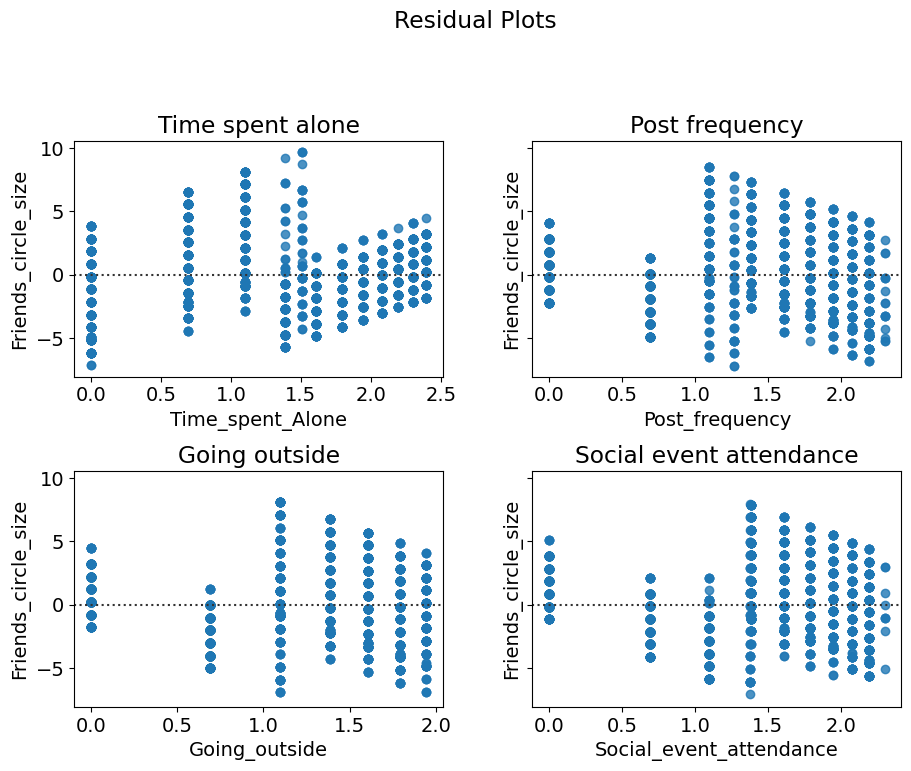

In [640]:
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
fig.suptitle("Residual Plots")
fig.tight_layout(pad=3.0)

plots_info = [
    {
        "name": "Time_spent_Alone",
        "title": "Time spent alone",
        "axes": (0, 0)
    },
    {
        "name": "Post_frequency",
        "title": "Post frequency",
        "axes": (0, 1)
    },
    {
        "name": "Going_outside",
        "title": "Going outside",
        "axes": (1, 0)
    },
    {
        "name": "Social_event_attendance",
        "title": "Social event attendance",
        "axes": (1, 1)
    }
]

print("Residual standard error: {}".format(np.std(residuals).iloc[0]))

for plot in plots_info:
    y_axis = plot["axes"][0]
    x_axis = plot["axes"][1]
    position = axes[y_axis, x_axis]
    sns.residplot(transformed_df, x=plot["name"], y="Friends_circle_size", ax=position)
    position.set_title(plot["title"])


## Prediction

In [641]:
B = model.params
print(B)

time_alone = B.iloc[1]
post_freq = B.iloc[2]
outside = B.iloc[3]
events = B.iloc[4]

# Regression variables were log transformed
y = time_alone*np.log(4.0) + post_freq*np.log(1.0) + + outside*np.log(5.0) + events*np.log(7.0)
y

Intercept                  2.855101
Time_spent_Alone          -0.937510
Post_frequency             0.669027
Going_outside              2.027706
Social_event_attendance    1.632142
dtype: float64


np.float64(5.139802893842577)